In [ ]:
#------------------------------- SDR Lib -------------------------------
import adi

In [3]:
#------------------------------- Libraries -------------------------------
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from scipy.signal import spectrogram
import matplotlib.gridspec as gridspec

In [2]:
#------------------------------- SDR Setup -------------------------------

sdr             = adi.Pluto("ip:192.168.1.31")      # SDR IP
sdr.sample_rate = 2e6                               # Sample Rate RX and TX
sdr.loopback    = 0                                 # 0=Disabled, 1=Digital, 2=RF
#Tx:
sdr.tx_lo                 = int(915e6)              # TX Carrier frequency
sdr.tx_hardwaregain_chan0 = -35                     # Attenuation applied to TX path, valid range is -90 to 0 dB [dB]
sdr.tx_rf_bandwidth       = int(125e3)              # Bandwidth of front-end analog filter of TX path [Hz]
sdr.tx_cyclic_buffer      = False
# Rx:
sdr.rx_lo                   = int(915e6)            # RX Carrier frequency
sdr.gain_control_mode_chan0 = "fast_attack"         # Receive path AGC Options: slow_attack, fast_attack, manual
sdr.rx_rf_bandwidth         = int(125e3)            # Bandwidth of front-end analog filter of RX path [Hz]
sdr.rx_cyclic_buffer        = False
sdr.rx_buffer_size          = 2**20 

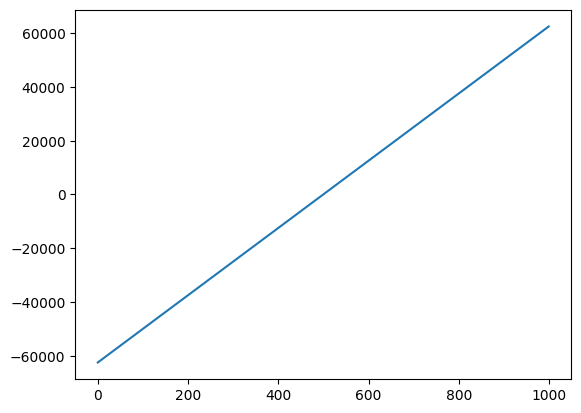

In [16]:
# Generate frequency function fc(t)
def generate_fc_t(bandwidth , SF , n_samples, up):
    B = bandwidth / 2
    Ts = (2**SF) / B
    t = np.linspace(-Ts/2, Ts/2, n_samples)
    if up == True:
        fc_t = ( bandwidth / Ts ) * t
    else:
        fc_t = - ( bandwidth / Ts ) * t
    return t, fc_t

In [5]:
# Modified f_c(t) function for generate another symbol
def rotate_fc_t(t, fc_t, cantidad):
    cantidad = -1*cantidad
    n_samples = len(t)
    cantidad = cantidad % n_samples

    new_t = np.zeros_like(t)
    new_fc_t = np.zeros_like(fc_t)

    for i in range(n_samples):
        new_t[i] = t[(i - cantidad) % n_samples]
        new_fc_t[i] = fc_t[(i - cantidad) % n_samples] - 125000

    return new_t, new_fc_t

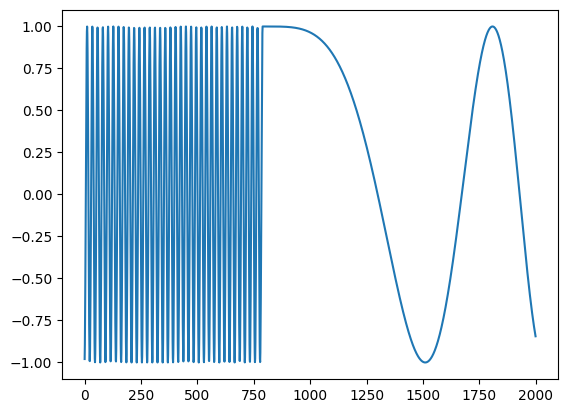

In [29]:
# Generate chirp function
def generate_chirp(bandwidth, sf, samples_per_chip, symbol, up):
    B = bandwidth / 2
    Ts = (2**sf) / B
    m = samples_per_chip * (2**sf)
    t, fc_t = generate_fc_t(bandwidth, sf, m, up)
    t, fc_t = rotate_fc_t(t, fc_t , symbol * samples_per_chip)
    chirp = np.exp(1j * 2 *np.pi * fc_t * t)
    return t, chirp

_, chirp = generate_chirp(125e3, 8, 90, 125, False)
plt.plot(np.real(chirp[11000:13000]))
plt.show()

In [7]:
# Generate preamble
def generate_preamble(amount, bandwidth, sf, samples_per_chip):
    preamble = np.array([])
    for i in range(amount):
        _, chirp = generate_chirp(bandwidth, sf, samples_per_chip, 0, True)
        preamble = np.concatenate((preamble, chirp))
    return _, preamble

In [8]:
# Generate sync word
def generate_sync_word(bandwitdh, sf, samples_per_chip):
    sync_word = np.array([])
    _, first = generate_chirp(bandwitdh, sf, samples_per_chip, 0, False)
    _, second = generate_chirp(bandwitdh, sf, samples_per_chip, 0, False)
    sync_word = np.concatenate((first, second))
    return sync_word

81920


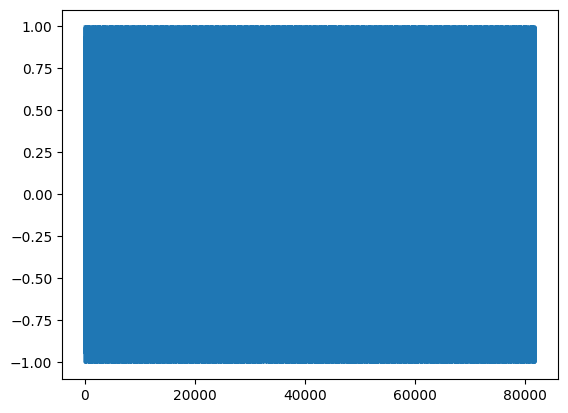

In [9]:
# Generate package
def generate_pkg(amount, bandwitdh, sf, samples_per_chip):
    package = np.array([])
    _, preamble = generate_preamble(8, bandwitdh, sf, samples_per_chip)
    sync_word = generate_sync_word(bandwitdh, sf, samples_per_chip)
    package = np.concatenate((preamble, sync_word))
    for i in range(amount):
        symbol = random.randint(0, (2**sf)-1)
        _, chirp = generate_chirp(bandwitdh, sf, samples_per_chip, symbol, True)
        package = np.concatenate((package, chirp))
    return package

package = generate_pkg(10, 125e3, 8, 16)
print(len(package))
plt.plot(np.real(package))
plt.show()

In [9]:
def pkg_brute_force(amount, bandwitdh, sf, samples_per_chip, guess_i, guess_j):
    package = np.array([])
    t, preamble = generate_preamble(8, bandwitdh, sf, samples_per_chip)
    
    _, chirp_to_guess_i = generate_chirp(bandwitdh, sf, samples_per_chip, guess_i, True)
    package = np.concatenate((preamble, chirp_to_guess_i))
    _, chirp_to_guess_j = generate_chirp(bandwitdh, sf, samples_per_chip, guess_j, True)
    package = np.concatenate((package, chirp_to_guess_j))
    
    sync_word = generate_sync_word(bandwitdh, sf, samples_per_chip)
    package = np.concatenate((package, sync_word))
    
    for i in range(amount):
        symbol = random.randint(0, (2**sf)-1)
        _, chirp = generate_chirp(bandwitdh, sf, samples_per_chip, symbol, True)
        package = np.concatenate((package, chirp))
    return package

In [10]:
# Generate a spectrogram
def plot_spectrogram(title, rx_signal, samples):
    plt.figure(figsize=(20,4), dpi= 80, facecolor='w', edgecolor='k')
    ff, tt, Sxx = spectrogram(rx_signal , fs =samples, nperseg=512, noverlap=512/2, mode='psd', return_onesided= False)
    plt.pcolormesh(tt, ff, (Sxx), shading='gouraud')
    plt.title(title)
    plt.ylabel('Frequency')
    plt.colorbar(label='Power (dB)')
    plt.axis(ymax = 0)
    plt.axis(ymin= -35000)
    plt.grid(alpha=0.4)
    x_min, x_max, _, _ = plt.axis()
    plt.xticks(np.arange(x_min, x_max, x_max/44))
    plt.show()

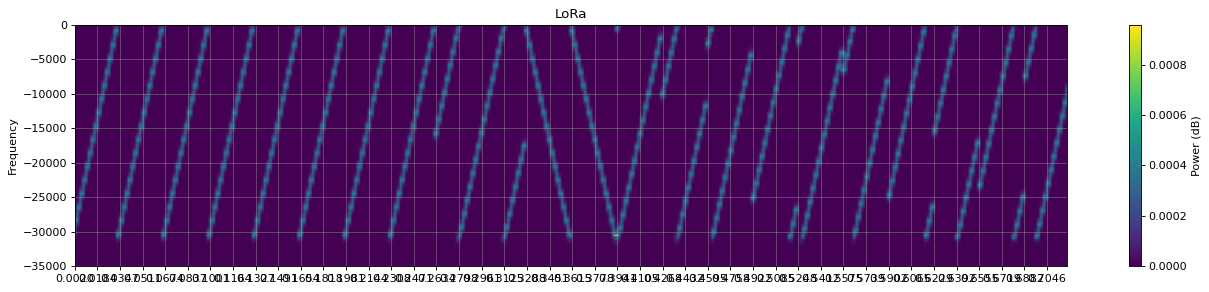

In [11]:
plot_spectrogram("LoRa", (pkg_brute_force(10, 125e3, 8, 16, 120, 120)), 125e3)

In [ ]:
i=0
j=0
while(i<=255):
    package = pkg_brute_force(10, 125e3, 8, 16, i, j)
    tx_signal = package
    sdr.tx(tx_signal*(2**14-1))
    print("Transmitted:")
    print("i=",i,"j=",j)
    
    if (j>=255):
        i=i+1
        j=0
    else:
        j=j+1
    
    if (i>=255):
        i=0

In [ ]:
# Since it is not possible to turn off Tx, it is configured to transmit at low power and on a different frequency than Rx.
sdr.tx_destroy_buffer()
TxAtten  = -90
RxLOFreq = 2400e6
sdr.tx(np.zeros(2048))

In [ ]:
# Destoy SDR Object
del(sdr)